### ***Preparing the environnement:***

In [ ]:
# Download the external library "pydicom"
!pip install pydicom
# Import necessary local libraries
import os
import xlrd
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import Model
from tensorflow.keras.models import load_model
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

     |████████████████████████████████| 1.9MB 8.4MB/s 


### ***Preparing the INbreast dataset:***

In [ ]:
# List of "training" images
tr_data = os.listdir('/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end/Training_Data')
# List of "test" images
ts_data = os.listdir('/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end/Test_Data')
# Nnumber of "training" images
print ('Training data:',len(tr_data),'images')
# Nnumber of "test" images
print('Test data:',len(ts_data),'images')

Training data: 280 images
Test data: 107 images


### ***Setting up the model and the variables for feature extraction:***

In [ ]:
# Load the model
cnn_vgg = load_model('/content/drive/My Drive/BRIKI PFE 2020/Hypothesis/inbreast_vgg16_[512-512-1024]x2_hybrid.h5')
cnn_vgg.summary()
# Set a feature extractor from a specific layer
ft_ext_vgg = Model(inputs=cnn_vgg.input,outputs=cnn_vgg.get_layer('global_average_pooling2d_1').output)
# Set a 3D numpy array of zeros to temporarily stock an image
img_zeros=np.zeros(shape=(1152, 896,3))
# Set a 1D numpy array of zeros where to concatenate the extracted features
ft_zeros=np.zeros((1,1024))
# Set input paths 
img_train='/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end/Training_Data'
img_test='/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end/Test_Data'
# Set the output path where to save extracted features and labels
output='/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end'


In [ ]:
from keras.applications.vgg16 import decode_predictions
# Load the model
model = load_model('/content/drive/My Drive/BRIKI PFE 2020/Hypothesis/inbreast_vgg16_[512-512-1024]x2_hybrid.h5')
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
# load image
img1=('/content/drive/MyDrive/BRIKI PFE 2020/Datasets/Test/DCMs/20587080_b6a4f750c6df4f90_MG_R_ML_ANON.dcm')
img2 = pydicom.read_file(img1)
img3 = img2.pixel_array
img4=img3*(255/16383) 
img5 = resize(img4, [1152, 896], anti_aliasing=True)
img_zeros[:,:,0]=img5
img_zeros[:,:,1]=img5
img_zeros[:,:,2]=img5
img_final=np.expand_dims(img_zeros,0)
# predict the probability across all output classes
yhat = model.predict(img_final)
yhat.tolist()

[[0.6308309435844421, 0.36916911602020264]]

### ***Features extraction: training features***

In [ ]:
for root, dirs, files in os.walk(img_train):
  # Browse images in a-z order
  for file in sorted(files):
    img1 = os.path.join(img_train, file)
    # Read an image and preprocess it
    img2 = pydicom.read_file(img1)
    img3 = img2.pixel_array
    img4=img3*(255/16383) 
    img5 = resize(img4, [1152, 896], anti_aliasing=True)
    img_zeros[:,:,0]=img5
    img_zeros[:,:,1]=img5
    img_zeros[:,:,2]=img5
    img_final=np.expand_dims(img_zeros,0)
    # Here feature extraction
    ft_tr=ft_ext_vgg.predict(img_final)
    ft_zeros=np.concatenate((ft_zeros,ft_tr),axis=0)
ft_final=np.delete(ft_zeros, 0, 0)
# Save features array with the specified name
ft_path=os.path.join(output,'vgg_tr_ft')
np.save(file=ft_path,arr=ft_final)

### ***Features extraction: test features***

In [ ]:
for root, dirs, files in os.walk(img_test):
  # Browse images in a-z order
  for file in sorted(files):
    img1 = os.path.join(img_test, file)
    # Read an image and preprocess it
    img2 = pydicom.read_file(img1)
    img3 = img2.pixel_array
    img4=img3*(255/16383) 
    img5 = resize(img4, [1152, 896], anti_aliasing=True)
    img_zeros[:,:,0]=img5
    img_zeros[:,:,1]=img5
    img_zeros[:,:,2]=img5
    img_final=np.expand_dims(img_zeros,0)
    # Here feature extraction
    ft_tr=ft_ext_vgg.predict(img_final)
    ft_zeros=np.concatenate((ft_zeros,ft_tr),axis=0)
ft_final=np.delete(ft_zeros, 0, 0)
# Save features array with the specified name
ft_path=os.path.join(output,'vgg_ts_ft')
np.save(file=ft_path,arr=ft_final)

### ***Preparing the labels:***

In [ ]:
# Access and open labels "xlsx" file
location='/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end/Labels/labels_finalVersion.xlsx'
lb1 = xlrd.open_workbook(location)
lb2 = lb1.sheet_by_index(0)
lb3=lb2.col_values(0)
# Load labels in a numpy array
lbs_final=np.array(lb3)
# Split labels to training and test
tr_lbs=lbs_final[0:280] #280 labels
ts_lbs=lbs_final[280:387]   #107 labels

# Save labels arrays
tr_lbs_path=os.path.join(output,'tr_lbs')
ts_lbs_path=os.path.join(output,'ts_lbs')
np.save(file=tr_lbs_path,arr=tr_lbs)
np.save(file=ts_lbs_path,arr=ts_lbs)

### ***Checking features and labels shape:***

In [ ]:
# Load previously saved features and labels
vgg_tr_ft=np.load('/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end/vgg_tr_ft.npy')
vgg_ts_ft=np.load('/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end/vgg_ts_ft.npy')
tr_lbs=np.load('/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end/tr_lbs.npy')
ts_lbs=np.load('/content/drive/MyDrive/BRIKI PFE 2020/Datasets/INbreast_for_end-to-end/ts_lbs.npy')
# Print shapes
print('Size of training features:',vgg_tr_ft.shape)
print('Size of test features:',vgg_ts_ft.shape)
print('Size of training labels:',tr_lbs.shape)
print('Size of test labels:',ts_lbs.shape)


Size of training features: (280, 1024)
Size of test features: (107, 1024)
Size of training labels: (280,)
Size of test labels: (107,)


### ***Classification with SVM:***

Accuracy: 0.9719626168224299
Precision: 1.0
Recall: 0.7
F1-score: 0.8235294117647058


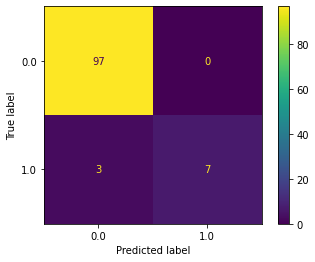

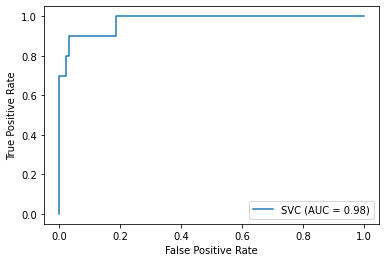

In [ ]:
# Call SVM classif
svm_cls = svm.SVC()
# Training SVM
svm_cls.fit(vgg_tr_ft, tr_lbs)
# Testing SVM
svm_lbs_pred = svm_cls.predict(vgg_ts_ft)
# Print evaluation metrics
print("Accuracy:",metrics.accuracy_score(ts_lbs, svm_lbs_pred))
print("Precision:",metrics.precision_score(ts_lbs, svm_lbs_pred))
print("Recall:",metrics.recall_score(ts_lbs, svm_lbs_pred))
print("F1-score:",metrics.f1_score(ts_lbs, svm_lbs_pred))
metrics.plot_confusion_matrix(svm_cls, vgg_ts_ft, ts_lbs)
metrics.plot_roc_curve(svm_cls, vgg_ts_ft, ts_lbs)
plt.show()

### ***Classification with Multi-layer Perceptron:***

Accuracy: 0.9626168224299065
Precision: 0.75
Recall: 0.9
F1-score: 0.8181818181818182


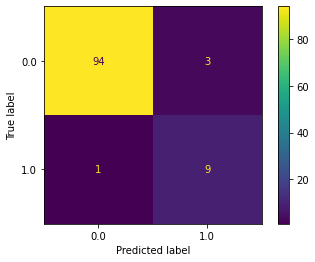

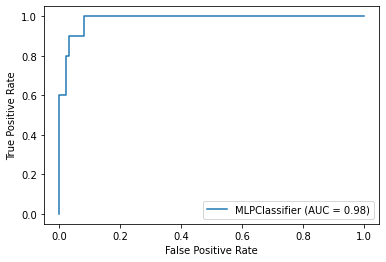

In [ ]:
# Call ANN classif
ann_cls = MLPClassifier(solver='adam', hidden_layer_sizes=(500, 150), max_iter=20000)
# Training ANN
ann_cls.fit(vgg_tr_ft,tr_lbs)
# Testing ANN
ann_lbs_pred = ann_cls.predict(vgg_ts_ft)
# Print evaluation metrics
# Print evaluation metrics
print("Accuracy:",metrics.accuracy_score(ts_lbs, ann_lbs_pred))
print("Precision:",metrics.precision_score(ts_lbs, ann_lbs_pred))
print("Recall:",metrics.recall_score(ts_lbs, ann_lbs_pred))
print("F1-score:",metrics.f1_score(ts_lbs, ann_lbs_pred))
metrics.plot_confusion_matrix(ann_cls, vgg_ts_ft, ts_lbs)
metrics.plot_roc_curve(ann_cls, vgg_ts_ft, ts_lbs)
plt.show()

### ***Classification with Random Forest:***

Accuracy: 0.9626168224299065
Precision: 0.75
Recall: 0.9
F1-score: 0.8181818181818182


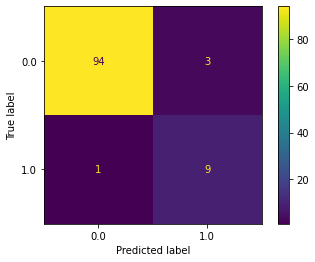

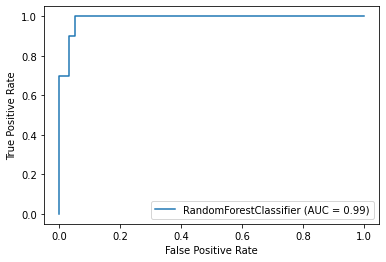

In [ ]:
# Call RF classif
rf_cls = RandomForestClassifier()
# Training RF
rf_cls.fit(vgg_tr_ft,tr_lbs)
RandomForestClassifier(...)
# Testing RF
rf_lbs_pred = rf_cls.predict(vgg_ts_ft)
# Print evaluation metrics
print("Accuracy:",metrics.accuracy_score(ts_lbs, rf_lbs_pred))
print("Precision:",metrics.precision_score(ts_lbs, rf_lbs_pred))
print("Recall:",metrics.recall_score(ts_lbs, rf_lbs_pred))
print("F1-score:",metrics.f1_score(ts_lbs, rf_lbs_pred))
metrics.plot_confusion_matrix(rf_cls, vgg_ts_ft, ts_lbs)
metrics.plot_roc_curve(rf_cls, vgg_ts_ft, ts_lbs)
plt.show()

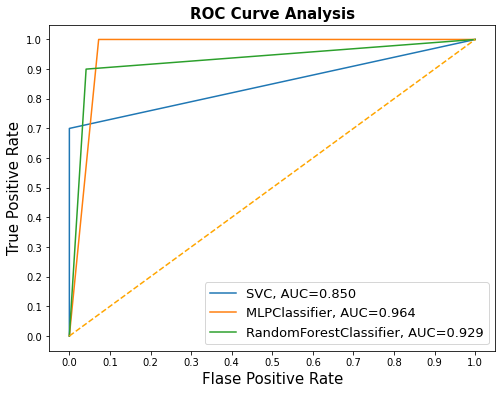

In [ ]:
classifiers = [svm.SVC(),
               MLPClassifier(solver='adam', hidden_layer_sizes=(500, 150), max_iter=20000),
               RandomForestClassifier()]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(vgg_tr_ft,tr_lbs)
    y = model.predict(vgg_ts_ft)
    
    fpr, tpr, _ = metrics.roc_curve(ts_lbs,  y)
    auc = metrics.roc_auc_score(ts_lbs, y)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

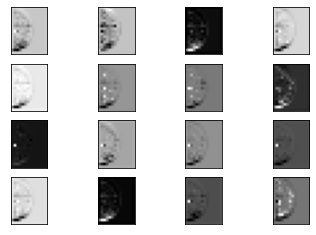

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = load_model('/content/drive/My Drive/BRIKI PFE 2020/Hypothesis/inbreast_vgg16_[512-512-1024]x2_hybrid.h5')
# redefine model to output right after the first hidden layer
model = Model(inputs=cnn_vgg.input,outputs=cnn_vgg.get_layer('conv2d_1').output)
img2 = pydicom.read_file('/content/drive/MyDrive/BRIKI PFE 2020/Datasets/Test/DCMs/20586934_6c613a14b80a8591_MG_L_CC_ANON.dcm')
img3 = img2.pixel_array
img4=img3*(255/16383) 
img5 = resize(img4, [1152, 896], anti_aliasing=True)
img_zeros=np.zeros(shape=(1152, 896,3))
img_zeros[:,:,0]=img5
img_zeros[:,:,1]=img5
img_zeros[:,:,2]=img5
img=np.expand_dims(img_zeros,0)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 4
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()
pyplot.savefig('ft_vis.png')

In [ ]:
a=load_model(VGG16)
a.summary()